In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install google-cloud-bigquery pandas pyarrow db-dtypes

In [ ]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated.")

Authenticated.


In [ ]:
from google.cloud import bigquery
import pandas as pd

# PROJECT_ID = "sfo-lakehouse-226"
PROJECT_ID = "sfo-lakehouse-226-478502"
client = bigquery.Client(project=PROJECT_ID)
print("Connected to:", client.project)

Connected to: sfo-lakehouse-226-478502


In [ ]:
datasets = ["sfo_raw", "sfo_core", "sfo_marts"]

for ds in datasets:
    dataset_id = f"{PROJECT_ID}.{ds}"
    dataset = bigquery.Dataset(dataset_id)
    dataset.location = "US"
    try:
        client.create_dataset(dataset)
        print("Created:", dataset_id)
    except Exception:
        print("Already exists:", dataset_id)

Already exists: sfo-lakehouse-226-478502.sfo_raw
Already exists: sfo-lakehouse-226-478502.sfo_core
Already exists: sfo-lakehouse-226-478502.sfo_marts


In [ ]:
import io

df_passenger = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Air_Traffic_Passenger_Statistics.csv")
df_landings  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Air_Traffic_Landings_Statistics.csv")

print("Passenger shape:", df_passenger.shape)
print("Landings shape :", df_landings.shape)
df_passenger.head()


Passenger shape: (38370, 15)
Landings shape : (44172, 17)


,Activity Period,Activity Period Start Date,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,data_as_of,data_loaded_at
0,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,31432,2025/08/21 08:21:35 AM,2025/08/22 03:03:24 PM
1,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,31353,2025/08/21 08:21:35 AM,2025/08/22 03:03:24 PM
2,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,2518,2025/08/21 08:21:35 AM,2025/08/22 03:03:24 PM
3,199907,1999/07/01,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Deplaned,Other,Terminal 2,D,1324,2025/08/21 08:21:35 AM,2025/08/22 03:03:24 PM
4,199907,1999/07/01,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Enplaned,Other,Terminal 2,D,1198,2025/08/21 08:21:35 AM,2025/08/22 03:03:24 PM


In [ ]:
df_passenger["Activity Period"] = df_passenger["Activity Period"].astype("int64")
df_landings["Activity Period"]  = df_landings["Activity Period"].astype("int64")
print("Converted Activity Period to int64")

Converted Activity Period to int64


In [ ]:
from google.cloud import bigquery

job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")

table_pass = f"{PROJECT_ID}.sfo_raw.passenger_raw"
table_land = f"{PROJECT_ID}.sfo_raw.landings_raw"

job = client.load_table_from_dataframe(df_passenger, table_pass, job_config=job_config)
job.result()
print("Loaded:", table_pass)

job = client.load_table_from_dataframe(df_landings, table_land, job_config=job_config)
job.result()
print("Loaded:", table_land)

Loaded: sfo-lakehouse-226-478502.sfo_raw.passenger_raw
Loaded: sfo-lakehouse-226-478502.sfo_raw.landings_raw


In [ ]:
for t in ["passenger_raw", "landings_raw"]:
    q = f"SELECT COUNT(*) AS row_count FROM `{PROJECT_ID}.sfo_raw.{t}`"
    print(t, client.query(q).to_dataframe().iloc[0]["row_count"])


passenger_raw 38370
landings_raw 44172


**Analysis**

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
PROJECT_ID = "sfo-lakehouse-226-478502"
client = bigquery.Client(project = PROJECT_ID)

In [ ]:
query = """
SELECT
  date_id,
  year,
  month,
  operating_airline,
  passengers_per_landing
FROM `sfo-lakehouse-226-478502.sfo_marts.mart_passengers_per_landing`
WHERE operating_airline = 'UNITED AIRLINES'
ORDER BY date_id
"""

df = client.query(query).to_dataframe()

In [ ]:
df.head()

,date_id,year,month,operating_airline,passengers_per_landing
0,199907,1999,7,UNITED AIRLINES,242.934291
1,199907,1999,7,UNITED AIRLINES,249.225806
2,199907,1999,7,UNITED AIRLINES,316.266129
3,199907,1999,7,UNITED AIRLINES,331.113821
4,199907,1999,7,UNITED AIRLINES,586.419355


In [ ]:
df.shape

(1978, 5)

In [ ]:
df["year_month"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str) + "-01")

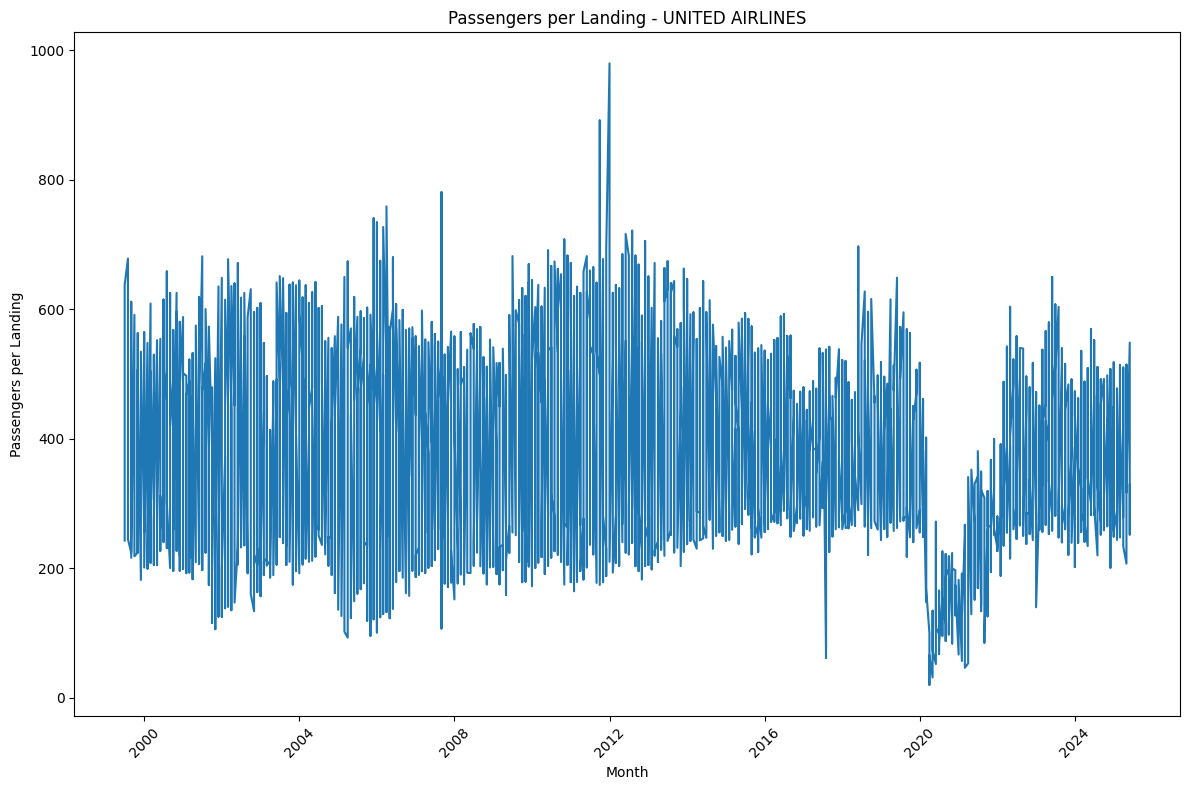

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df["year_month"], df["passengers_per_landing"])
plt.title("Passengers per Landing - UNITED AIRLINES")
plt.xlabel("Month")
plt.ylabel("Passengers per Landing")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Passengers per Landing - UNITED AIRLINES.png')
plt.show()

In [ ]:
df_sample = df[df['year'] >= 2020]

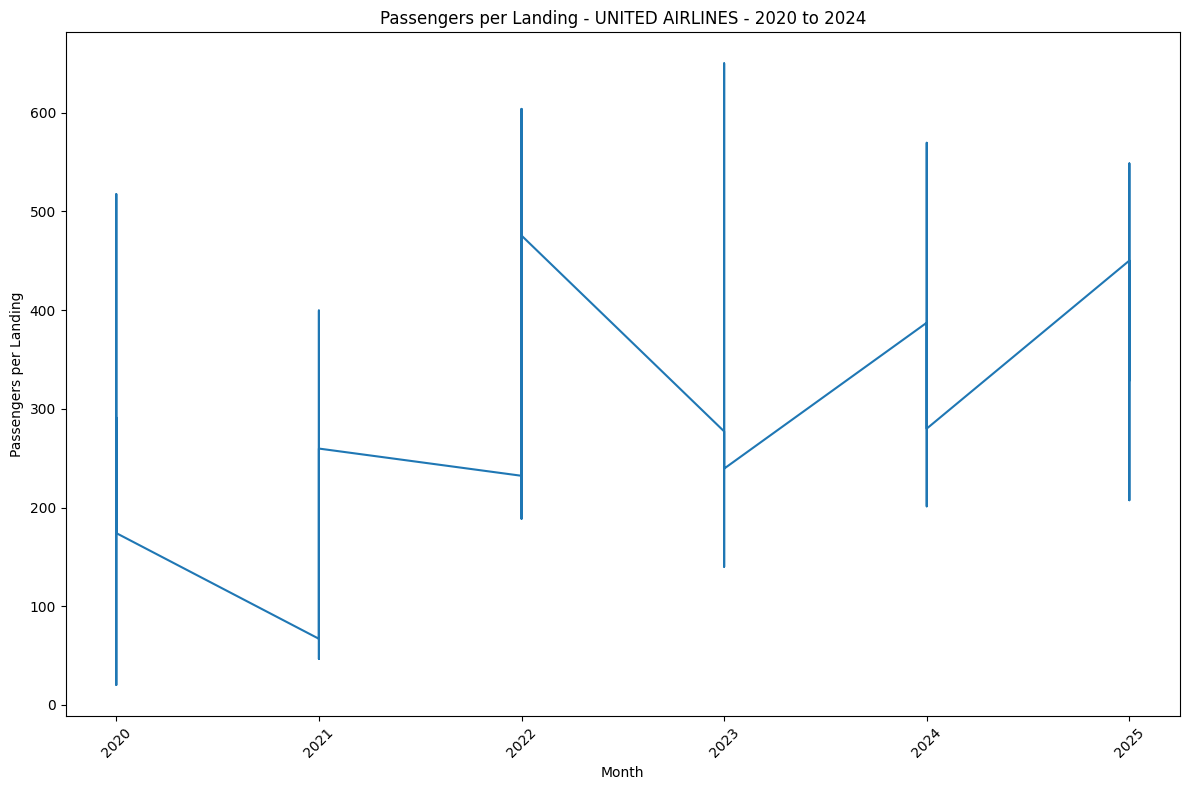

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df_sample['year'], df_sample["passengers_per_landing"])
plt.title("Passengers per Landing - UNITED AIRLINES - 2020 to 2024")
plt.xlabel("Month")
plt.ylabel("Passengers per Landing")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Passengers per Landing - UNITED AIRLINES - 2020 to 2024.png')
plt.show()

In [ ]:
from google.colab import files

In [ ]:
files.download('Passengers per Landing - UNITED AIRLINES.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>